## Download the Dataset

In [11]:
import tifffile
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from careamics import CAREamist
from careamics.config import create_n2v_configuration
from careamics.utils.metrics import scale_invariant_psnr

sys.path.append('library')

import library.dataset as dataset


In [3]:

# Downlaod the Dataset
root_path = Path("notebooks/data/bsd68")
dataset.load_bsd68_dataset(root_path)

# The Dataset is already split into Training, Validation, Testing and Grand Truths
data_path = Path(root_path / "denoising-N2V_BSD68.unzip/BSD68_reproducibility_data")
train_path = data_path / "train"
val_path = data_path / "val"
test_path = data_path / "test" / "images"
gt_path = data_path / "test" / "gt"


Loading BSD68 Dataset
BSD68 Dataset Loaded at notebooks/data/bsd68


## Visualize the Dataset

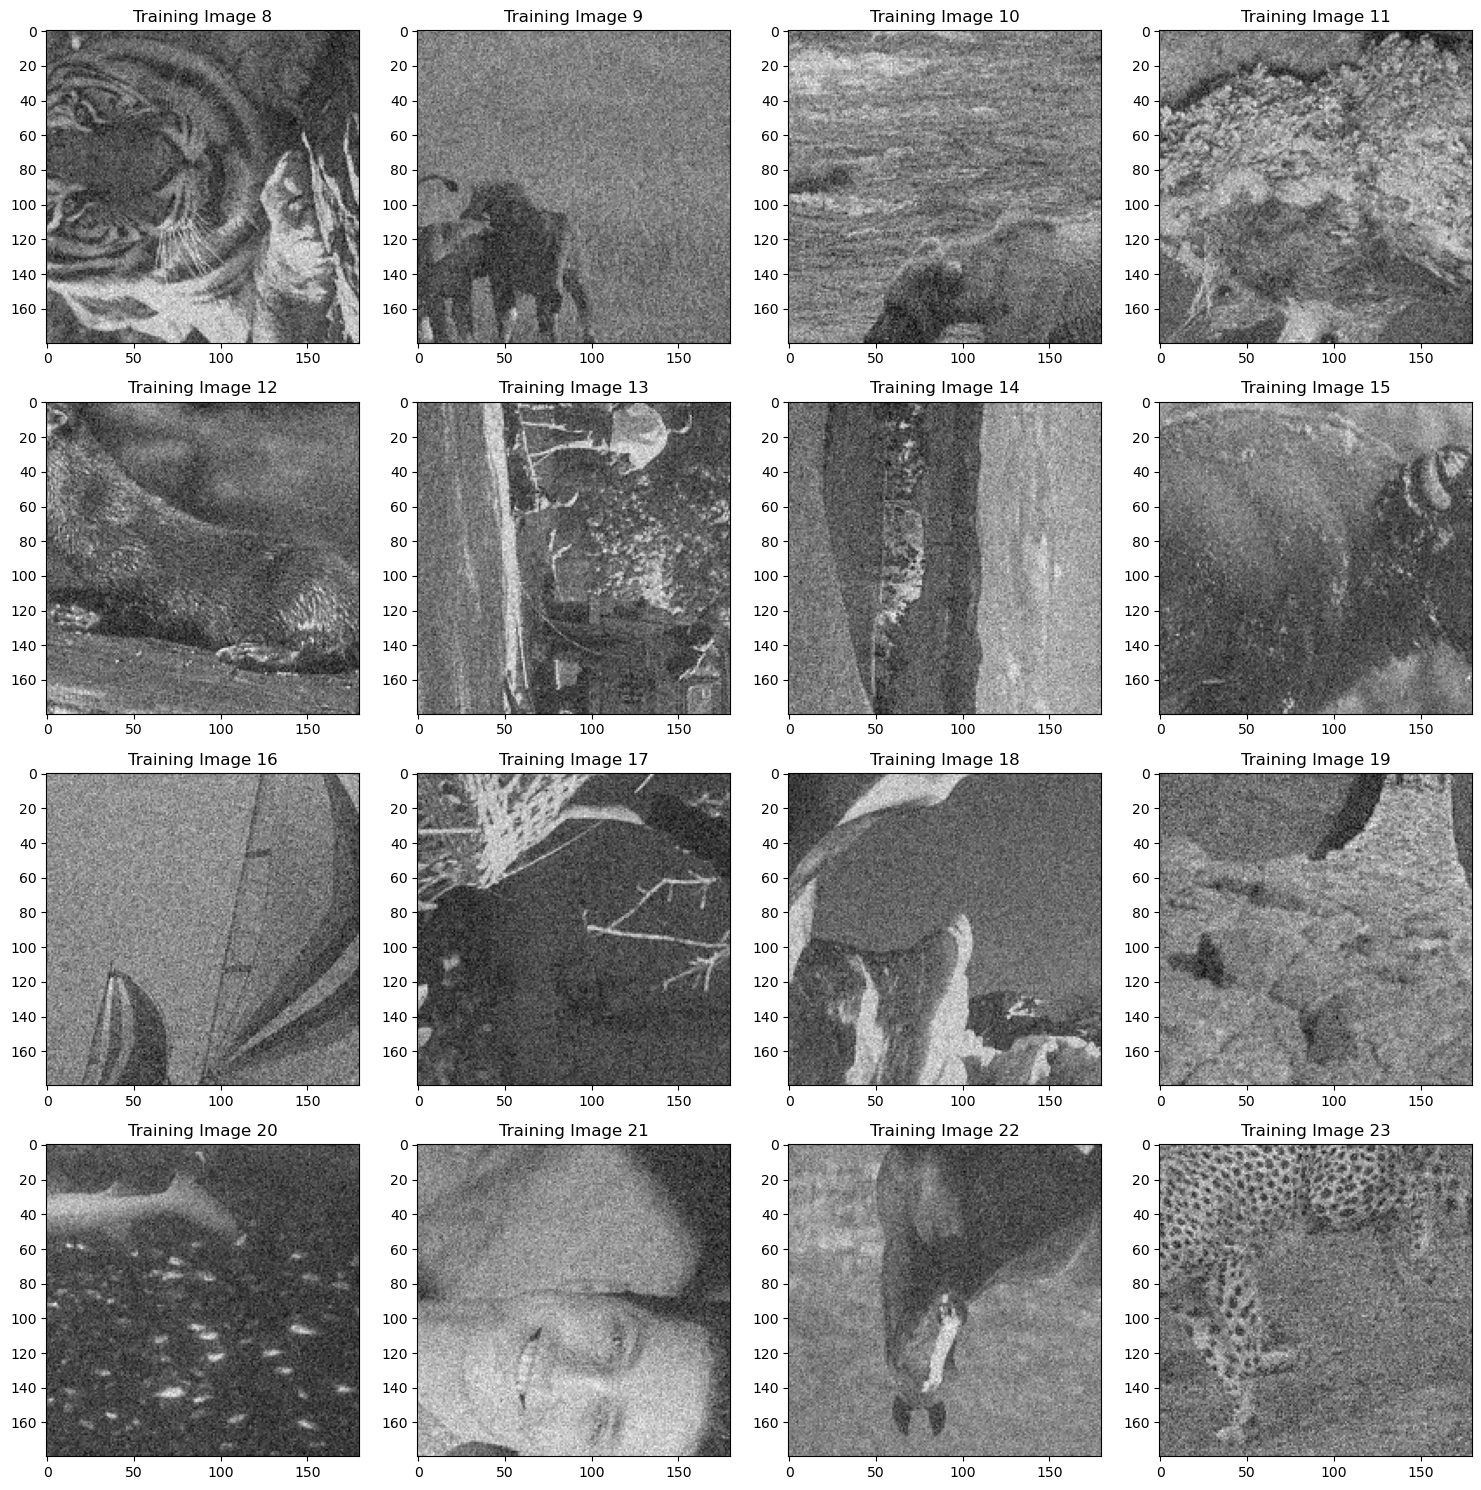

In [4]:

train_images = tifffile.imread(next(iter(train_path.rglob("*.tiff")))) # 3168 images
val_images = tifffile.imread(next(iter(val_path.rglob("*.tiff"))))
starting_index = 8 #Change this to show different images

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 15))

for ax, idx in zip(axes.flat, range(starting_index, starting_index + 16)): #Couples the axes with the indexes
    ax.imshow(train_images[idx], cmap="gray")
    ax.set_title(f"Training Image {idx}")
    
plt.tight_layout()
plt.show()


## Create the Training Configuration

In [52]:
config = create_n2v_configuration(
    experiment_name="bsd68_n2v",
    data_type="tiff",
    axes="SYX",
    patch_size=(64, 64),
    batch_size=64,
    num_epochs=10,
)

print(config)

{'algorithm_config': {'algorithm': 'n2v',
                      'loss': 'n2v',
                      'lr_scheduler': {'name': 'ReduceLROnPlateau',
                                       'parameters': {}},
                      'model': {'architecture': 'UNet',
                                'conv_dims': 2,
                                'depth': 2,
                                'final_activation': 'None',
                                'in_channels': 1,
                                'independent_channels': True,
                                'n2v2': False,
                                'num_channels_init': 32,
                                'num_classes': 1},
                      'optimizer': {'name': 'Adam',
                                    'parameters': {'lr': 0.0001}}},
 'data_config': {'axes': 'SYX',
                 'batch_size': 64,
                 'data_type': 'tiff',
                 'patch_size': [64, 64],
                 'transforms': [{'flip_x': True,
     

## Train the Model

In [53]:
# Before proceding, make sure your GPU is available to PyTorch or the training will be very slow

careamist = CAREamist(source=config, work_dir="notebooks/models/bsd68")

# train model
print(f"Training starting now...")
careamist.train(train_source=train_path, val_source=val_path)
print("Training ended!")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training starting now...


Extracted 28512 patches from input array.
Computed dataset mean: [110.753006], std: [63.603966]
Extracted 36 patches from input array.
/home/pippo/anaconda3/envs/n2v/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /mnt/c/Users/Filippo Corti/Documents/GitHub/PrincipiEModelliDellaPercezione/notebooks/models/bsd68/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | UNet | 509 K  | train
---------------------------------------
509 K     Trainable params
0         Non-trainable params
509 K     Total params
2.037     Total estimated model params size (MB)


Sanity Checking DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.25it/s]

/home/pippo/anaconda3/envs/n2v/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


/home/pippo/anaconda3/envs/n2v/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/pippo/anaconda3/envs/n2v/lib/python3.10/site-packages/pydantic/main.py:347: UserWarning: Pydantic serializer warnings:
  Expected `float` but got `float32` - serialized value may not be as expected
  Expected `float` but got `float32` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


Epoch 9: 100%|██████████| 446/446 [00:43<00:00, 10.15it/s, train_loss_step=0.217, val_loss=0.21, train_loss_epoch=0.209]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 446/446 [00:44<00:00, 10.13it/s, train_loss_step=0.217, val_loss=0.21, train_loss_epoch=0.209]
Training ended!


## Generate Predictions

In [54]:

output_path = "notebooks/predictions/bsd68/predictions.tiff"

prediction = careamist.predict(
    source=test_path,
    axes="YX",
    tile_size=(128, 128),
    tile_overlap=(48, 48),
    batch_size=1,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: |                                                             | 1632/? [00:45<00:00, 35.97it/s]


## Visualize the Predictions

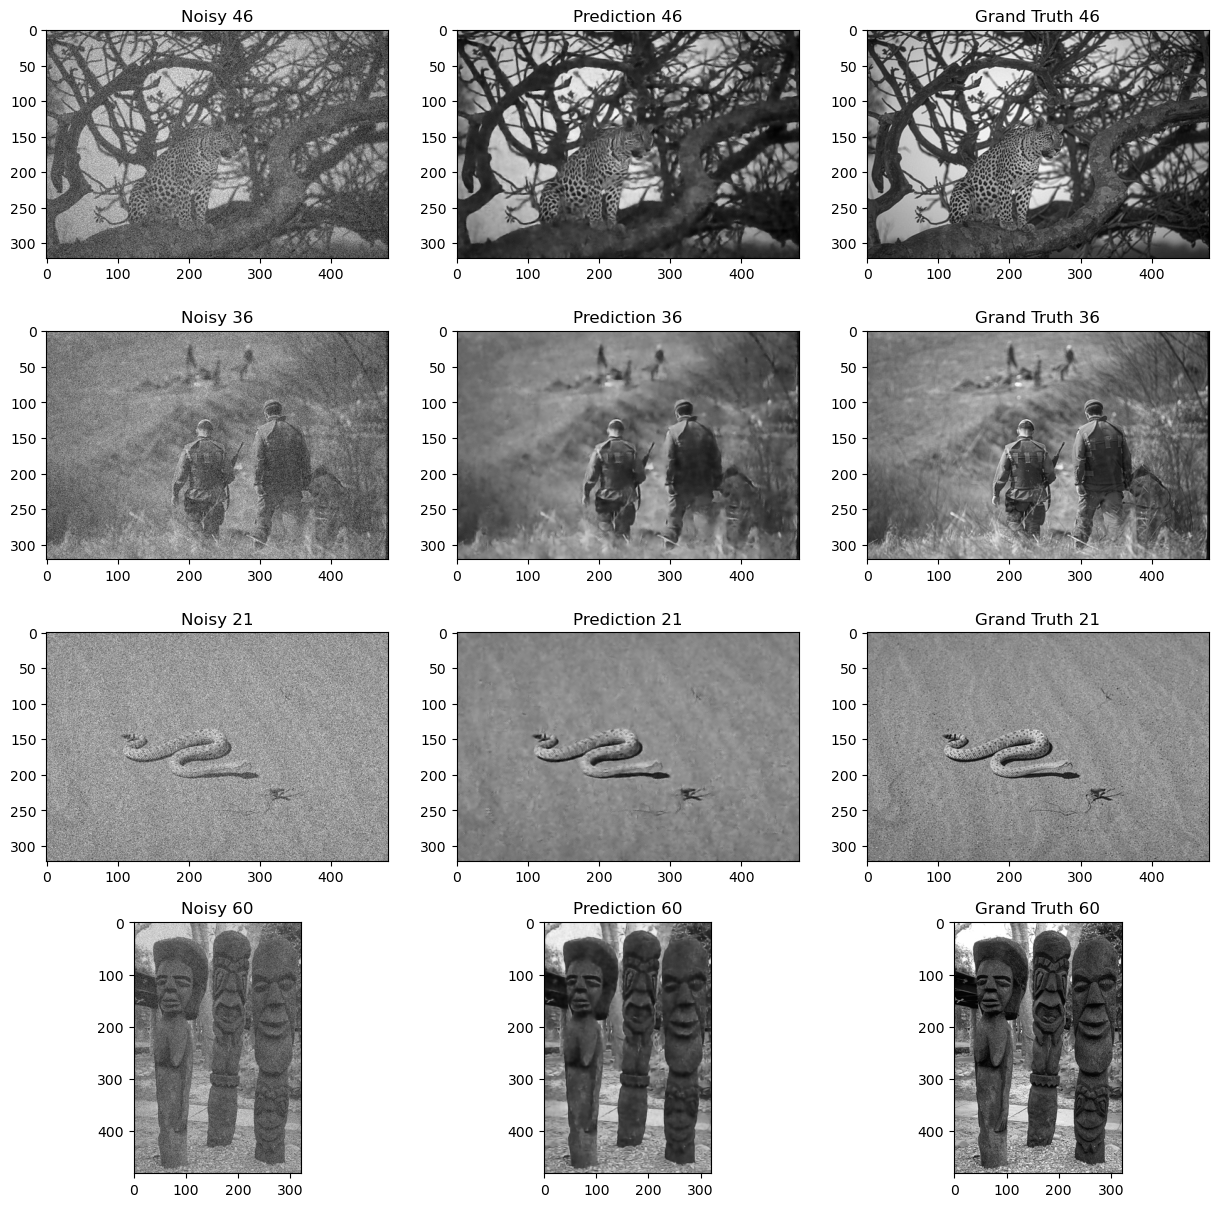

In [56]:
n = 4

test_images = [tifffile.imread(f) for f in sorted(test_path.glob("*.tiff"))]
ground_truth_images = [tifffile.imread(f) for f in sorted(gt_path.glob("*.tiff"))]

random_indexes = np.random.choice(range(len(test_images)), n)

fig, ax = plt.subplots(4, 3, figsize=(15, 15))
for a, i in zip(range(n), random_indexes):
    ax[a, 0].imshow(test_images[i], cmap="gray")
    ax[a, 0].set_title(f"Noisy {i}")
    ax[a, 1].imshow(prediction[i].squeeze(), cmap="gray")
    ax[a, 1].set_title(f"Prediction {i}")
    ax[a, 2].imshow(ground_truth_images[i], cmap="gray")
    ax[a, 2].set_title(f"Grand Truth {i}")